In [2]:
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer

In [68]:
df = pd.read_csv('train.csv')
print(df.shape)
df.head(3)

(25392, 19)


,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN29581,2,0,1,3,Meal Plan 1,0,Room_Type 1,200,2018,8,29,Online,0,0,0,90.95,0,Canceled
1,INN06326,2,0,1,3,Meal Plan 1,0,Room_Type 1,79,2018,3,24,Online,0,0,0,90.95,1,Canceled
2,INN33900,2,0,1,4,Meal Plan 1,0,Room_Type 4,78,2018,4,6,Online,0,0,0,99.45,1,Not_Canceled


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25392 entries, 0 to 25391
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            25392 non-null  object 
 1   no_of_adults                          25392 non-null  int64  
 2   no_of_children                        25392 non-null  int64  
 3   no_of_weekend_nights                  25392 non-null  int64  
 4   no_of_week_nights                     25392 non-null  int64  
 5   type_of_meal_plan                     25392 non-null  object 
 6   required_car_parking_space            25392 non-null  int64  
 7   room_type_reserved                    25392 non-null  object 
 8   lead_time                             25392 non-null  int64  
 9   arrival_year                          25392 non-null  int64  
 10  arrival_month                         25392 non-null  int64  
 11  arrival_date   

In [69]:
df = df.drop(["arrival_year", "arrival_month", "arrival_date"], axis=1)

In [70]:
category_cols = ["type_of_meal_plan", "required_car_parking_space", "room_type_reserved", "market_segment_type", "repeated_guest"]
for col in category_cols:
    display(df[col].value_counts())
    print("#" * 50)

Meal Plan 1     19492
Not Selected     3560
Meal Plan 2      2338
Meal Plan 3         2
Name: type_of_meal_plan, dtype: int64

##################################################


0    24596
1      796
Name: required_car_parking_space, dtype: int64

##################################################


Room_Type 1    19684
Room_Type 4     4242
Room_Type 6      667
Room_Type 2      498
Room_Type 5      186
Room_Type 7      111
Room_Type 3        4
Name: room_type_reserved, dtype: int64

##################################################


Online           16210
Offline           7398
Corporate         1427
Complementary      272
Aviation            85
Name: market_segment_type, dtype: int64

##################################################


0    24753
1      639
Name: repeated_guest, dtype: int64

##################################################


In [71]:
meal_plan = {"Meal Plan 1": 0, "Not Selected": 1, "Meal Plan 2": 2, "Meal Plan 3": 3}
df['type_of_meal_plan'] = df['type_of_meal_plan'].map(meal_plan)

room_type = {
    "Room_Type 1": 0,
    "Room_Type 4": 1,
    "Room_Type 6": 3,
    "Room_Type 2": 2,
    "Room_Type 5": 4,
    "Room_Type 7": 5,
    "Room_Type 3": 6
}
df['room_type_reserved'] = df['room_type_reserved'].map(room_type)

market_segment = {
    "Online": 1,
    "Offline": 0,
    "Corporate": 2,
    "Complementary": 4,
    "Aviation": 3
}
df['market_segment_type'] = df['market_segment_type'].map(market_segment)

In [72]:
category_cols = ["type_of_meal_plan", "required_car_parking_space", "room_type_reserved", "market_segment_type", "repeated_guest"]
for col in category_cols:
    display(df[col].value_counts())
    print("#" * 50)

0    19492
1     3560
2     2338
3        2
Name: type_of_meal_plan, dtype: int64

##################################################


0    24596
1      796
Name: required_car_parking_space, dtype: int64

##################################################


0    19684
1     4242
3      667
2      498
4      186
5      111
6        4
Name: room_type_reserved, dtype: int64

##################################################


1    16210
0     7398
2     1427
4      272
3       85
Name: market_segment_type, dtype: int64

##################################################


0    24753
1      639
Name: repeated_guest, dtype: int64

##################################################


In [73]:
df["market_segment_type"].replace({3:4}).value_counts()

1    16210
0     7398
2     1427
4      357
Name: market_segment_type, dtype: int64

In [78]:
category_cols = ["type_of_meal_plan", "required_car_parking_space", "room_type_reserved", "market_segment_type", "repeated_guest"]
X_log_1_dummy = []
for col in category_cols:
    if col == "type_of_meal_plan":
        col_values = df[col].replace(3, 2)
    elif col == "room_type_reserved":
        col_values = df[col].replace({6:4, 5:4})
    elif col == "market_segment_type":
        col_values = df[col].replace({3:4})
    else:
        col_values = df[col]
    X_log_1_dummy.append(
        pd.get_dummies(col_values, prefix=col, prefix_sep='__', drop_first=True)
    )
X_log_1_dummy = pd.concat(X_log_1_dummy, axis=1)
df = pd.concat([df.drop(category_cols, axis=1), X_log_1_dummy], axis=1)

In [79]:
X = df.drop(["booking_status", "Booking_ID"], axis=1)
y = df["booking_status"]
# Decision Tree 학습/예측/평가
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

logreg = LogisticRegression()
X_train.shape

(20313, 20)

In [80]:
X_train.keys()

Index(['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'lead_time', 'no_of_previous_cancellations',
       'no_of_previous_bookings_not_canceled', 'avg_price_per_room',
       'no_of_special_requests', 'type_of_meal_plan__1',
       'type_of_meal_plan__2', 'required_car_parking_space__1',
       'room_type_reserved__1', 'room_type_reserved__2',
       'room_type_reserved__3', 'room_type_reserved__4',
       'market_segment_type__1', 'market_segment_type__2',
       'market_segment_type__4', 'repeated_guest__1'],
      dtype='object')

In [81]:
lr_model = LogisticRegression()
scores = cross_val_score(lr_model, X, y, cv=10)
print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

Cross Validation Scores:  [0.8023622  0.7992126  0.80582907 0.78613627 0.7912564  0.79992123
 0.79677038 0.79243797 0.8046475  0.80189051]
Average CV Score:  0.7980464129656105
Number of CV Scores used in Average:  10


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

In [48]:
auc_scores = []
for col in tqdm(X_train):
    logreg = LogisticRegression()
    logreg.fit(X_train[[col]], y_train)
    y_test_pred = logreg.predict_proba(X_test[[col]])[:,1]
    auc_scores.append([
        col,
        roc_auc_score(y_test, y_test_pred)
    ])
auc_scores = pd.DataFrame(auc_scores, columns=["col_name", "auc_score"])

  0%|          | 0/20313 [00:00<?, ?it/s]


ValueError: y should be a 1d array, got an array of shape (20313, 16) instead.

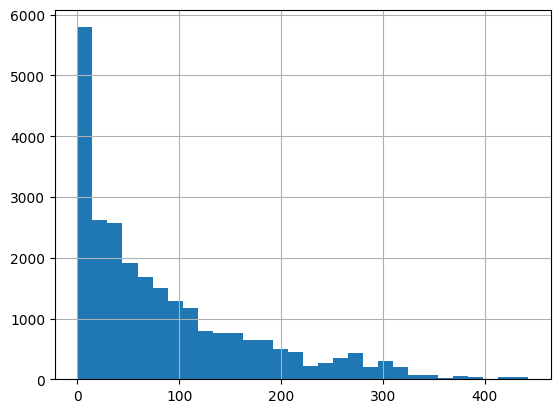

In [16]:
df["lead_time"].hist(bins=30);

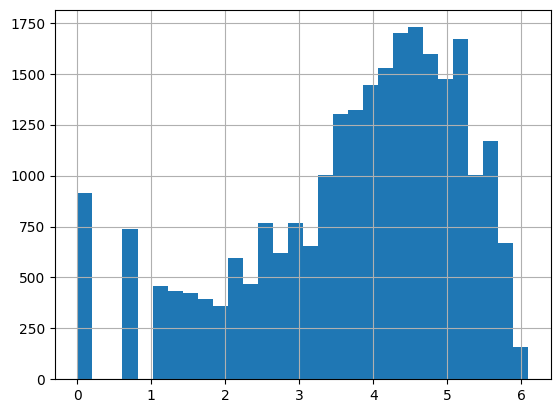

In [17]:
np.log1p(df["lead_time"]).hist(bins=30);

count    25367.000000
mean       103.245794
std         34.104010
min          0.000000
50%         99.900000
75%        120.165000
90%        147.900000
95%        165.000000
99%        207.900000
max        209.000000
Name: avg_price_per_room, dtype: float64

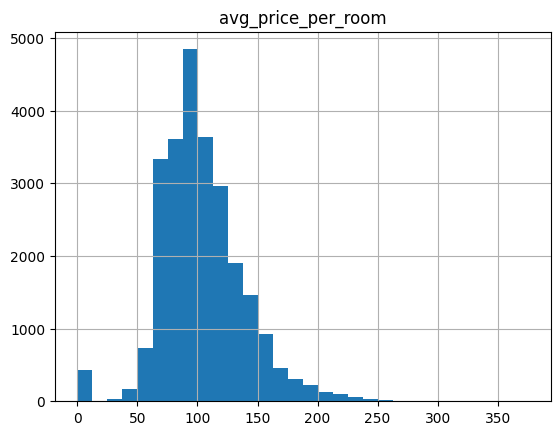

In [18]:
plt.title("avg_price_per_room")
df["avg_price_per_room"].hist(bins=30);
df["avg_price_per_room"].describe(percentiles=[.5, .75, .9, .95, .99])
df["avg_price_per_room"].apply(lambda x: 209 if x>209 else x).describe(percentiles=[.5, .75, .9, .95, .99])

In [32]:
copy_df = pd.DataFrame(df)
copy_df["lead_time"] = np.log1p(copy_df["lead_time"])
copy_df["avg_price_per_room/"] = copy_df["avg_price_per_room"].apply(lambda x: 209 if x>209 else x)

copy_df["lead_time__cut"] = pd.cut(copy_df["lead_time"], 15, labels=[f"lead_time__{i}" for i in range(1,16)])
copy_df["avg_price_per_room__cut"] = pd.cut(copy_df["avg_price_per_room"], 11, labels=[f"avg_price_per_room__{i}" for i in range(1,12)])

copy_df_dummy = [
    pd.get_dummies(copy_df["lead_time__cut"], prefix="lead_time", prefix_sep='__', drop_first=True),
    pd.get_dummies(copy_df["avg_price_per_room__cut"], prefix="avg_price_per_room", prefix_sep='__', drop_first=True)
]
copy_df = pd.concat([copy_df.drop(["lead_time", "lead_time__cut", "avg_price_per_room__cut"], axis=1)] + copy_df_dummy, axis=1)
copy_df.keys()

Index(['Booking_ID', 'no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'booking_status',
       'num_meal_plan', 'num_room_type', 'num_market_segment',
       'type_of_meal_plan__Meal Plan 2', 'type_of_meal_plan__Meal Plan 3',
       'type_of_meal_plan__Not Selected', 'required_car_parking_space__1',
       'room_type_reserved__Room_Type 2', 'room_type_reserved__Room_Type 3',
       'room_type_reserved__Room_Type 4', 'room_type_reserved__Room_Type 5',
       'room_type_reserved__Room_Type 6', 'room_type_reserved__Room_Type 7',
       'market_segment_type__Complementary', 'market_segment_type__Corporate',
       'market_segment_type__Offline', 'market_segment_type__Online',
       'repeated_guest__1',

In [36]:
copy_df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,market_segment_type,repeated_guest,...,avg_price_per_room__avg_price_per_room__2,avg_price_per_room__avg_price_per_room__3,avg_price_per_room__avg_price_per_room__4,avg_price_per_room__avg_price_per_room__5,avg_price_per_room__avg_price_per_room__6,avg_price_per_room__avg_price_per_room__7,avg_price_per_room__avg_price_per_room__8,avg_price_per_room__avg_price_per_room__9,avg_price_per_room__avg_price_per_room__10,avg_price_per_room__avg_price_per_room__11
0,INN29581,2,0,1,3,Meal Plan 1,0,Room_Type 1,Online,0,...,0,1,0,0,0,0,0,0,0,0
1,INN06326,2,0,1,3,Meal Plan 1,0,Room_Type 1,Online,0,...,0,1,0,0,0,0,0,0,0,0
2,INN33900,2,0,1,4,Meal Plan 1,0,Room_Type 4,Online,0,...,0,1,0,0,0,0,0,0,0,0
3,INN00721,2,0,2,0,Meal Plan 1,0,Room_Type 1,Offline,0,...,0,1,0,0,0,0,0,0,0,0
4,INN22121,2,1,0,4,Meal Plan 1,0,Room_Type 1,Online,0,...,0,1,0,0,0,0,0,0,0,0


In [35]:


feature_names = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'required_car_parking_space',
       'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests',
       'type_of_meal_plan__Meal Plan 2', 'type_of_meal_plan__Meal Plan 3',
       'type_of_meal_plan__Not Selected', 'required_car_parking_space__1',
       'room_type_reserved__Room_Type 2', 'room_type_reserved__Room_Type 3',
       'room_type_reserved__Room_Type 4', 'room_type_reserved__Room_Type 5',
       'room_type_reserved__Room_Type 6', 'room_type_reserved__Room_Type 7',
       'market_segment_type__Complementary', 'market_segment_type__Corporate',
       'market_segment_type__Offline', 'market_segment_type__Online',
       'repeated_guest__1', 'avg_price_per_room/', 'lead_time__lead_time__2',
       'lead_time__lead_time__3', 'lead_time__lead_time__4',
       'lead_time__lead_time__5', 'lead_time__lead_time__6',
       'lead_time__lead_time__7', 'lead_time__lead_time__8',
       'lead_time__lead_time__9', 'lead_time__lead_time__10',
       'lead_time__lead_time__11', 'lead_time__lead_time__12',
       'lead_time__lead_time__13', 'lead_time__lead_time__14',
       'lead_time__lead_time__15', 'avg_price_per_room__avg_price_per_room__2',
       'avg_price_per_room__avg_price_per_room__3',
       'avg_price_per_room__avg_price_per_room__4',
       'avg_price_per_room__avg_price_per_room__5',
       'avg_price_per_room__avg_price_per_room__6',
       'avg_price_per_room__avg_price_per_room__7',
       'avg_price_per_room__avg_price_per_room__8',
       'avg_price_per_room__avg_price_per_room__9',
       'avg_price_per_room__avg_price_per_room__10',
       'avg_price_per_room__avg_price_per_room__11']


X = copy_df[feature_names]
y = copy_df["booking_status"]
# smote = SMOTE(random_state = 42)
# Decision Tree 학습/예측/평가
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
# X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

# Decision Tree 학습/예측/평가
# dt_model = DecisionTreeClassifier(
#     max_depth=20, min_samples_leaf=8, min_samples_split=6, criterion="gini", max_features=10)
pipe = Pipeline([
    ('standard', StandardScaler()),
    ('model', LogisticRegression(random_state=42))
])
cores_ce = cross_val_score(pipe, copy_df.drop("booking_status", axis=1), copy_df["booking_status"], cv=10, scoring='roc_auc')
print(f"AUC mean: {cores_ce.mean():.4f}")

AUC mean: nan


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\p